## Plan

Итак, нам надо:
 - распаковать mp3 в массив чисел, представляющий собой график зависимости амплитуды звука от времени (sox)
 - определить, какие ноты звучат в каждый конкретный момент времени
 - определить, какие аккорды образуют эти ноты

### Итак, что происходит:
    С помощью get_spec_from_wav получаем спектограмму песни (дцб и время)
        Сделали мы это с помощью преобразования Фурье
        
    Пытаемся получить chromagram (chroma feature - https://en.wikipedia.org/wiki/Chroma_feature)
    Чтобы определить, какие играют ноты
    Для начала мы удалим весь шум, чтобы выделить ноты поверх шума.
        
        Гармо́ника (лат. harmonica) — дополнительный тон, который по частоте всегда выше основного тона, причём строго кратно 
        числам натурального ряда (то есть, выше по частоте в 2, 3, 4, 5 и более раз).

In [2]:
CHORD_PATH_FOR_TEST = "D:\\iba_project_data\\Guitar_Only\\a\\a1.wav"
TMP_SONG = "tmp.wav"

In [3]:
%matplotlib inline

# librosa - module for work with sounds

import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy

In [4]:
def get_spec_from_wav(file_path, with_graphics=False):
    """
    Func gets spectogram from wav-file.
    
    Input:
        file_path - path to file with sound.
        with_graphics - paint graphics of wav and sperctogram.
    
    Return:
        Xdb - decibels.
        sr - Sample rate used to determine time scale. 
        (частота дискретизации) 
    
    """
    
    x, sr = librosa.load(file_path)
    if with_graphics:
        plt.figure(figsize=(14, 5))    
        librosa.display.waveplot(x, sr=sr)
    
    X = librosa.stft(x) # Short-time Fourier transform
    Xdb = librosa.amplitude_to_db(abs(X))
    
    if with_graphics:
        plt.figure(figsize=(14, 5))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar()
    
    return Xdb, sr

In [26]:
def get_chromagram(file_path, with_graphics=False):
    y, sr = librosa.load(file_path)
    chroma_orig = librosa.feature.chroma_cqt(y=y, sr=sr)        
    
    # We can correct for minor tuning deviations by using 3 CQT bins per semi-tone, instead of one
    chroma_os = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=12*3)

    #isolating the harmonic component. We’ll use a large margin for separating harmonics from percussives
    y_harm = librosa.effects.harmonic(y=y, margin=8)
    chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, bins_per_octave=12*3)

    # non-local filtering
    # Each data point (e.g, spectrogram column) is replaced by aggregating its nearest neighbors in feature space.
    chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm,
                                                       aggregate=np.median,
                                                       metric='cosine'))

    # Local discontinuities and transients can be suppressed by using a horizontal median filter.
    chroma_smooth = scipy.ndimage.median_filter(chroma_filter, size=(1, 9))

    if with_graphics:
        # First, let’s plot the original chroma
        # For display purposes, let's zoom in on a 15-second chunk from the middle of the song
        idx = tuple([slice(None), slice(*list(librosa.time_to_frames([45, 60])))])

        # And for comparison, we'll show the CQT matrix as well.
        C = np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3))


        plt.figure(figsize=(12, 4))
        plt.subplot(2, 1, 1)
        librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max)[idx],
                                 y_axis='cqt_note', x_axis='time', bins_per_octave=12*3)
        plt.colorbar()
        
        plt.subplot(2, 1, 2)
        librosa.display.specshow(chroma_smooth[idx], y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.ylabel('Median-filtered')
        
        # Automatically adjust subplot parameters to give specified padding.
        plt.tight_layout()    
    return chroma_smooth

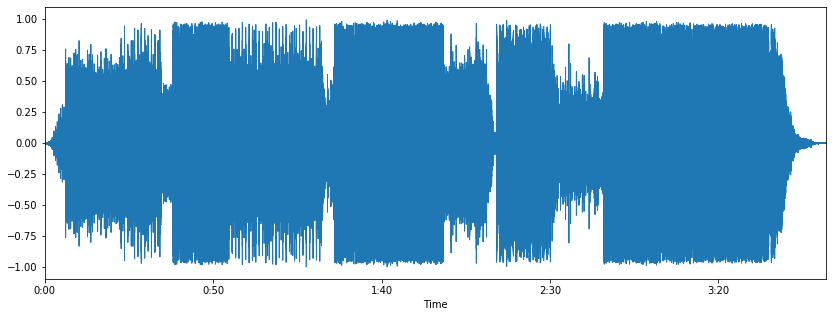

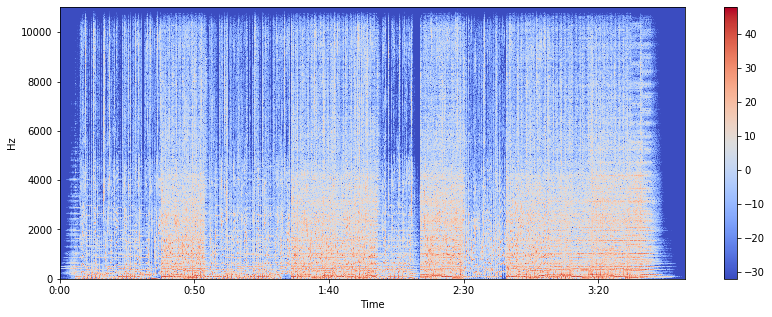

In [16]:
Xdb, sr = get_spec_from_wav(TMP_SONG)

In [27]:
a = get_chromagram(TMP_SONG)

In [35]:
for i in range(12):
    print(a[i][0])

0.4411258461441936
0.06423147189373633
0.009775755237285345
0.009133026627209325
0.021735229321424618
0.0082100650411769
0.007061004778861408
0.029706406011997408
0.18676798518609133
1.0
0.14732068256640168
0.08512125786797092


A B H C C#/Db D D#/Eb E F F#/Gb G G#/Ab

Далее нужно добавить способ разделения песни на аккорды.

След этап - обучение на стандартных данных, мб их скомбинировать в датафрейм из двух колонок.

